In [1]:
from pymongo import MongoClient
import pandas as pd  
import numpy as np 

client = MongoClient('localhost', 27017)
db = client['twitter']

pipeline=[{ "$project": {  "id_user" : 1, "originalTweet" : 1, "hashtag" : 1, "mention" : 1} }]

cursor_list = list(db['tweets'].aggregate(pipeline))

tweets = pd.DataFrame(cursor_list)
data = pd.DataFrame(columns=['Tweets'])
data['Tweets'] = tweets['originalTweet']
# data['user_id'] = tweets['id_user']
# data['len']  = np.array([len(tweet) for tweet in data['Tweets']])
# data['hahtags'] = tweets['hashtag']
# data['mentions'] = tweets['mention']
# user = list()
# for i in range(0,len(tweets)):
#     user.append(tweets['user'][i]['name'])
# data['user'] = np.array(user)

In [6]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from nltk.tokenize import word_tokenize
from utils import tokenize_and_stem

docs = data['Tweets']

myStopWords=set(stopwords.words('english')+list(['http','https']))                             

tagged_data = [TaggedDocument(words=tokenize_and_stem(_d, stopwords=myStopWords), tags=[str(i)]) for i, _d in enumerate(docs)]
#tag = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [7]:
print(tagged_data[:1])

[TaggedDocument(words=['debcha', 'people', 'influenced', 'ursula', 'franklin', 'died', 'last', 'weekend', 'collected', 'tweetslinks', 'https'], tags=['0'])]


![title](img/W2V_D2V.png)


In [7]:
#train model

In [ ]:
model = Doc2Vec(vector_size=100, dbow_words= 1, dm=0,  window=5, seed=1337, min_count=5, workers=12,alpha=0.025, min_alpha=0.025)
model.build_vocab(tagged_data)
for epoch in range(10):
    print("epoch "+str(epoch))
    model.train(tagged_data, total_examples=len(tagged_data), epochs=1)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5


In [ ]:
model.save("d2v.model")
print("Model Saved")

In [ ]:
# model = Doc2Vec.load("d2v.model")  # you can continue training with the loaded model!

In [11]:
print(model)

Doc2Vec(dbow+w,d100,n5,w5,mc5,s0.001,t12)


In [13]:
X = model[model.wv.vocab]

In [14]:
#Kmeans - Elbow Method

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1).fit(X)
    Sum_of_squared_distances.append(km.inertia_)

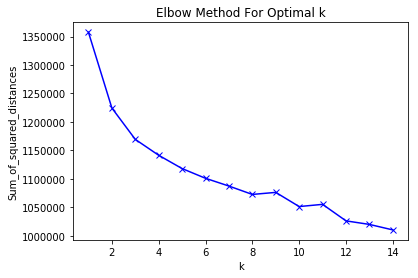

In [20]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
# from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import collections
 
k=5

kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Counter({4: 98954, 2: 96252, 3: 40526, 1: 26560, 0: 17765})
98954


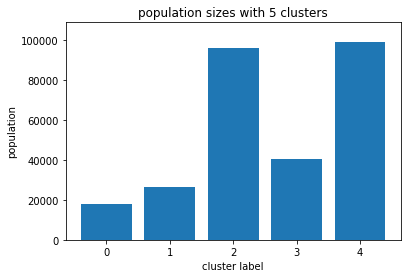

In [34]:
 labels = kmeans.labels_
centroids = kmeans.cluster_centers_

counter=collections.Counter(labels)
y=list(counter.most_common())[0][1]
  

plt.bar(range(len(set(labels))), np.bincount(labels))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(k));

# truncate y axis to see the rest better
plt.ylim(0,y+10000);

print (counter)
print (y)

# silhouette_score = silhouette_score(X, labels, metric='euclidean')
# print ('silhouette score: ', silhouette_score)

# plt.savefig('ClusterDistribution_Doc2Vec.png')

In [ ]:
#Describe Clusters

#The most similar document vectors to your centroid to see typical cluster members

In [37]:
from sklearn.neighbors import NearestNeighbors

centroids=kmeans.cluster_centers_

neighbors = NearestNeighbors(n_neighbors=5)

neighbors.fit(X)

#It returns [[<DISTANCE>]], and [[<EL_INDEX>]] (indexes start at 0).
# terms=neighbors.kneighbors([centroids[5]])[1]

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [38]:
for i in range(0,len(centroids)):
    terms=neighbors.kneighbors([centroids[i]])[1]
    top_terms=[]
    for t in terms[0]:
        top_terms.append(model.wv.index2entity[t])
    print('Top terms cluster {} : {}'.format(i,top_terms))

Top terms cluster 0 : ['defencegirl', 'nodding', 'tcosrcajggtzf', 'uproxxsports', 'dealtaker']
Top terms cluster 1 : ['pertanian', 'sambo', 'barrosromo', 'semifinais', 'mavens']
Top terms cluster 2 : ['quiltdad', 'tulugan', 'bryanschatz', 'kommentare', 'batmanghelidjh']
Top terms cluster 3 : ['theeuropean', 'earice', 'impartial', 'metrocdmx', 'língua']
Top terms cluster 4 : ['quiltdad', 'spenders', 'patrouille', 'crystalpalace', 'muñeca']


In [ ]:
# import sys

# sys.stdout = open("Cluster_Description_Doc2Vec->KMeans.txt", "w")

# for i in range(0,len(centroids)):
#     terms=neighbors.kneighbors([centroids[i]])[1]
#     top_terms=[]
#     for t in terms[0]:
#         top_terms.append(model.wv.index2entity[t])
#     print('Top terms cluster {} : {}'.format(i,top_terms))